# Requirements

In [2]:
# Add as many imports as you need.
import pandas as pd
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [9]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('climate-data.csv')

Explore the dataset using visualizations of your choice.

array([[<Axes: title={'center': 'meantemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'wind_speed'}>,
        <Axes: title={'center': 'meanpressure'}>]], dtype=object)

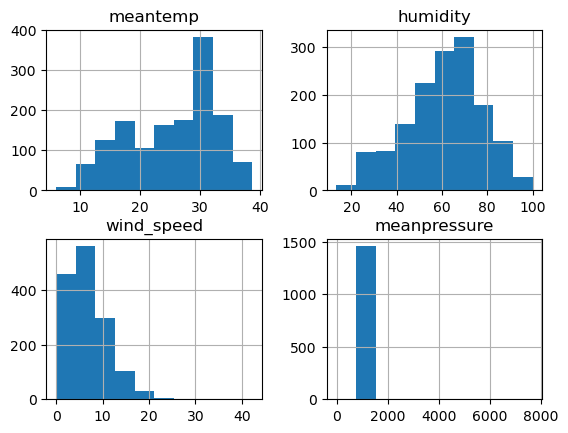

In [11]:
# Write your code here. Add as many boxes as you need.
data.hist()

In [12]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [13]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [14]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [16]:
# Write your code here. Add as many boxes as you need.
for lag in [3, 2, 1]:  # lag between 1 day and 3 days
    data[f'humidity_lag_{lag}'] = data['humidity'].shift(lag)
    data[f'wind_speed_lag_{lag}'] = data['wind_speed'].shift(lag)
    data[f'meanpressure_lag_{lag}'] = data['meanpressure'].shift(lag)

data = data.dropna()
data = data.drop(['humidity','wind_speed','meanpressure'], axis= 1)

In [17]:
data.head()

,meantemp,humidity_lag_3,wind_speed_lag_3,meanpressure_lag_3,humidity_lag_2,wind_speed_lag_2,meanpressure_lag_2,humidity_lag_1,wind_speed_lag_1,meanpressure_lag_1
date,,,,,,,,,,
2013-01-04,8.666667,84.500000,0.000000,1015.666667,92.000000,2.980000,1017.800000,87.000000,4.633333,1018.666667
2013-01-05,6.000000,92.000000,2.980000,1017.800000,87.000000,4.633333,1018.666667,71.333333,1.233333,1017.166667
2013-01-06,7.000000,87.000000,4.633333,1018.666667,71.333333,1.233333,1017.166667,86.833333,3.700000,1016.500000
2013-01-07,7.000000,71.333333,1.233333,1017.166667,86.833333,3.700000,1016.500000,82.800000,1.480000,1018.000000
2013-01-08,8.857143,86.833333,3.700000,1016.500000,82.800000,1.480000,1018.000000,78.600000,6.300000,1020.000000


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [63]:
# Write your code here. Add as many boxes as you need.
input = data.drop(['meantemp'], axis=1)
target = data['meantemp']

In [65]:
# Write your code here. Add as many boxes as you need.
input.head()

,humidity_lag_3,wind_speed_lag_3,meanpressure_lag_3,humidity_lag_2,wind_speed_lag_2,meanpressure_lag_2,humidity_lag_1,wind_speed_lag_1,meanpressure_lag_1
date,,,,,,,,,
2013-01-04,84.500000,0.000000,1015.666667,92.000000,2.980000,1017.800000,87.000000,4.633333,1018.666667
2013-01-05,92.000000,2.980000,1017.800000,87.000000,4.633333,1018.666667,71.333333,1.233333,1017.166667
2013-01-06,87.000000,4.633333,1018.666667,71.333333,1.233333,1017.166667,86.833333,3.700000,1016.500000
2013-01-07,71.333333,1.233333,1017.166667,86.833333,3.700000,1016.500000,82.800000,1.480000,1018.000000
2013-01-08,86.833333,3.700000,1016.500000,82.800000,1.480000,1018.000000,78.600000,6.300000,1020.000000


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(input, target, test_size=0.2, shuffle = False)

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [75]:
# Write your code here. Add as many boxes as you need.
import numpy as np

In [77]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [79]:
X_train = np.reshape(X_train,(X_train.shape[0],3,X_train.shape[1]))

ValueError: cannot reshape array of size 10503 into shape (1167,3,9)

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [27]:
# Write your code here. Add as many boxes as you need.

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [29]:
# Write your code here. Add as many boxes as you need.

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [31]:
# Write your code here. Add as many boxes as you need.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

In [33]:
# Write your code here. Add as many boxes as you need.

Use the trained model to make predictions for the test set.

In [35]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [37]:
# Write your code here. Add as many boxes as you need.

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

In [39]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

As a bonus task for this laboratory exercise, calculate the Simple Moving Average (SMA) and Weighted Moving Average (WMA) with 3 timesteps for `mean_temperature` over the past 1, 2, and 3 days:

- **SMA with 3 timesteps ($\text{SMA}_3$)** - the average of temperatures from the previous 3 days:  
  $SMA_3 = \frac{\text{mean\_temperaure}_{lag\_3} +\ \text{mean\_temperaure}_{lag\_2} +\ \text{mean\_temperaure}_{lag\_1}}{1\ +\ 1\ +\ 1}$.

- **WMA with 3 timesteps ($\text{WMA}_3$)** - a weighted average, giving more importance to recent days:  
  $WMA_3 = \frac{1\ \cdot\ \text{mean\_temperaure}_{lag\_3} +\ 2\ \cdot\ \text{mean\_temperaure}_{lag\_2} +\ 3\ \cdot\ \text{mean\_temperaure}_{lag_1}}{1\ +\ 2\ +\ 3}$.

Then use this indicators alongside the other features in the dataset to predict the `mean_temperaure`.

*Hint: Use the `rolling` method from `pandas`. Check the docs at the following link https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.*

In [42]:
# Write your code here. Add as many boxes as you need.